In [74]:
# import all necessary libraries
import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Convolution2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
import sys

import platform

# import keras-tuner 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from joblib import dump, load
import joblib

<h1>DATA PROCESSING</h1>

In [1]:
# define path for training and testing directories
train_dir = './Images/Training/'
test_dir = './Images/Testing/'

In [21]:
# read the image directories into a tf dataset, images are shuffled and normalized for size
# 20% of the training data is used for validation

IMG_SIZE = (180, 180)

#Train DataSet
train_dataset = keras.utils.image_dataset_from_directory(
  train_dir,
  label_mode='categorical',
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (IMG_SIZE),
  batch_size = 32)

#Validation DataSet
val_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (IMG_SIZE),
    batch_size = 32)

#Test DataSet
test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  seed = 123,
  shuffle = True,
  image_size = (IMG_SIZE),
  batch_size = 32)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [5]:
# Create a non-shuffled dataset without validation

IMG_SIZE = (180, 180)

#Train DataSet
tr_train_dataset = keras.utils.image_dataset_from_directory(
  train_dir,
  label_mode='categorical',
  shuffle = False,
  image_size = (IMG_SIZE),
  batch_size = 32)

#Test DataSet
tr_test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  shuffle = False,
  image_size = (IMG_SIZE),
  batch_size = 32)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [6]:
# Obtain the labels for the non-shuffled datasets
train_label = np.concatenate([y for x, y in tr_train_dataset], axis=0)
test_label = np.concatenate([y for x, y in tr_test_dataset], axis=0)

<h1>SEQ CNN</h1>

In [ ]:
# Cache the training dataset for quicker training
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [104]:
# rescale image 
normalization_layer = layers.Rescaling(1./255)

# Distort data to create varied dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
# create a funtion to build a model with variable parameters for use with keras tuner
def build_model(hp):
    num_classes = 4
    seq_model = keras.Sequential()
    seq_model.add(data_augmentation)
    seq_model.add(normalization_layer)
    # optimize the amount of convolutional layers as well as the size 
    for i in range(hp.Int('n_layers', 1, 4)):
        seq_model.add(layers.Conv2D(hp.Int(f'conv_{i}_units',
                                          min_value=32,
                                          max_value=256,
                                          step=32,), 1,
                                    padding='same'))
        seq_model.add(layers.BatchNormalization())
        seq_model.add(layers.Activation('relu'))
        seq_model.add(layers.MaxPooling2D())
        # optimize the dropout value
        seq_model.add(layers.Dropout(hp.Choice('dropout_valuec', values=[0.0,0.2,0.5])))
    seq_model.add(layers.Flatten())
    # optimize the size and amount of dense layers
    for r in range(hp.Int('d_layers', 1, 4)):
        seq_model.add(layers.Dense(hp.Int(f'dense_{r}_units',
                                         min_value=32,
                                         max_value=512,
                                         step=32)))
        seq_model.add(layers.Dropout(hp.Choice('dropout_valued', values=[0.0,0.2,0.5])))
        # optimize the type of activation
        seq_model.add(layers.Activation(hp.Choice(name=f'activation_{r}_type', 
                                                  values=['relu', 'sigmoid'],
                                                 default='relu')))
        
    seq_model.add(layers.Dense(num_classes, activation = 'softmax'))
    
    # optimize the learning rate of the model
    hp_learning_rate = hp.Float('learning_rate',
                               min_value=1e-4,
                               max_value=1e-2,
                               sampling='LOG',
                               default=1e-3)

    # compile the model
    seq_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])
    
    return seq_model


In [ ]:
# initialize keras tuner object
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=80,
    executions_per_trial=1,
)


In [ ]:
tuner.search_space_summary()

In [ ]:
# begin hyperparameter optimization
tuner.search(train_dataset,
            verbose=2,
            epochs=20,
            validation_data=val_dataset)

In [105]:
# Build the optimal model as discovered by keras tuning
num_classes = 4
seq_model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(64, 5, strides=1, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 5, strides=1, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(name='feature_layer'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256),
    layers.Activation('relu'),
    layers.Dense(128),
    layers.Activation('relu'),
    layers.Dense(num_classes, activation = 'softmax', name="outputs")
])

In [107]:
# compile the model
seq_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

In [110]:
# model training parameters
epochs = 1
history = seq_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)

143/143 [==============================] - 660s 5s/step - loss: 0.8664 - categorical_accuracy: 0.6584 - precision_1: 0.7395 - recall_1: 0.5298 - val_loss: 0.5326 - val_categorical_accuracy: 0.8074 - val_precision_1: 0.8340 - val_recall_1: 0.7785


In [111]:
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      4864      
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        102464    
                                                      

In [13]:
# stop if model has not improved within 10 epochs reload the best weights
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [15]:
# model training parameters
epochs = 20
history = seq_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[
        early_stopping_cb
    ]
)



Epoch 1/20
143/143 [==============================] - 6s 44ms/step - loss: 0.4480 - categorical_accuracy: 0.8344 - val_loss: 0.3571 - val_categorical_accuracy: 0.8809
Epoch 2/20
143/143 [==============================] - 7s 50ms/step - loss: 0.3585 - categorical_accuracy: 0.8639 - val_loss: 0.3158 - val_categorical_accuracy: 0.8853
Epoch 3/20
143/143 [==============================] - 7s 48ms/step - loss: 0.2753 - categorical_accuracy: 0.8950 - val_loss: 0.3332 - val_categorical_accuracy: 0.8888
Epoch 4/20
143/143 [==============================] - 7s 46ms/step - loss: 0.2493 - categorical_accuracy: 0.9074 - val_loss: 0.2461 - val_categorical_accuracy: 0.9116
Epoch 5/20
143/143 [==============================] - 7s 46ms/step - loss: 0.2016 - categorical_accuracy: 0.9230 - val_loss: 0.2321 - val_categorical_accuracy: 0.9186
Epoch 6/20
143/143 [==============================] - 7s 46ms/step - loss: 0.1910 - categorical_accuracy: 0.9274 - val_loss: 0.2432 - val_categorical_accuracy: 0.912

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 3, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd118144350>, 140536029179744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8152950>, 140536029318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8152950>, 140536029318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 64, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f813d090>, 140536029324800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 64, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f813d090>, 140536029324800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8159f50>, 140536029325760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8159f50>, 140536029325760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(129600, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8164c10>, 140536029331280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(129600, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8164c10>, 140536029331280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8177a10>, 140536029340848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8177a10>, 140536029340848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f818a810>, 140536029329360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f818a810>, 140536029329360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f819d650>, 140536029327360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f819d650>, 140536029327360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81a8650>, 140536029414304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81a8650>, 140536029414304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81b3410>, 140536029414784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81b3410>, 140536029414784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 3, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd118144350>, 140536029179744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 3, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd118144350>, 140536029179744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8152950>, 140536029318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8152950>, 140536029318720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 64, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f813d090>, 140536029324800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 64, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f813d090>, 140536029324800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8159f50>, 140536029325760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8159f50>, 140536029325760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(129600, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8164c10>, 140536029331280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(129600, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8164c10>, 140536029331280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8177a10>, 140536029340848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f8177a10>, 140536029340848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f818a810>, 140536029329360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f818a810>, 140536029329360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f819d650>, 140536029327360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f819d650>, 140536029327360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81a8650>, 140536029414304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81a8650>, 140536029414304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81b3410>, 140536029414784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fd0f81b3410>, 140536029414784), {}).


INFO:tensorflow:Assets written to: Brain_Tumor_Seq/assets


INFO:tensorflow:Assets written to: Brain_Tumor_Seq/assets


In [18]:
# saving our model
seq_model.save('Brain_Tumor_Seq')

INFO:tensorflow:Assets written to: Brain_Tumor_Seq\assets


INFO:tensorflow:Assets written to: Brain_Tumor_Seq\assets


In [19]:
seq_model = tf.keras.models.load_model("Brain_Tumor_Seq", compile = False)

In [ ]:
# graphing the accuracy and loss in both training and validation datasets
epochs = len(history.epoch)
accuracy = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# graphing the precision and recall in both training and validation datasets
epochs = len(history.epoch)
precision = history.history['precision_4']
val_acc = history.history['val_precision_4']

loss = history.history['recall_4']
val_loss = history.history['val_recall_4']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Recall')
plt.plot(epochs_range, val_loss, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')
plt.show()

In [24]:
# evaluate the model on the test data
scores = seq_model.evaluate(test_dataset)
scores

41/41 [==============================] - 36s 853ms/step - loss: 0.2168 - categorical_accuracy: 0.9466 - precision: 0.9495 - recall: 0.9458


[0.21682395040988922,
 0.9466056227684021,
 0.9494640231132507,
 0.9458428621292114]

<h1>SEQ KNN

In [9]:
# get our  feature extrtactor model by removing all layers after the final Max2DPooling Layer
kn_model=Model(inputs=seq_model.input,outputs=seq_model.get_layer('feature_layer').output)


In [10]:
# save feature extractor model
kn_model.save('Brain_Tumor_KNN')

INFO:tensorflow:Assets written to: Brain_Tumor_KNN\assets


INFO:tensorflow:Assets written to: Brain_Tumor_KNN\assets


In [11]:
# load feature extractor model
cnn_model = tf.keras.models.load_model('Brain_Tumor_KNN', compile=False)

In [12]:
# Obtain our extracted features by running the non shuffled dataset through the feature extraction model
cnn_train_x=cnn_model.predict(tr_train_dataset)
cnn_test_x=cnn_model.predict(tr_test_dataset)

41/41 [==============================] - 32s 785ms/step


In [62]:
# Obtain our y labels to use with the traditional classifiers
cnn_y_train=[ np.where(r==1)[0][0] for r in  train_label]
cnn_y_test=[ np.where(r==1)[0][0] for r in  test_label]

In [17]:
print(cnn_train_x.shape)
print(cnn_test_x.shape)

(5712, 45, 45, 64)
(1311, 45, 45, 64)


In [15]:
# resize the images into a single row
cnn_x_train=cnn_train_x.reshape(5712,45*45*64)
cnn_x_test=cnn_test_x.reshape(1311, 45*45*64)

In [30]:
# create and train our KNN classifier
cnn_knc=KNeighborsClassifier()
cnn_knc.fit(cnn_x_train,cnn_y_train)
cnn_knc.score(cnn_x_train,cnn_y_train)

0.9467787114845938

In [34]:
# save the model
dump(cnn_knc, 'cnn_knc.joblib')

['cnn_knc.joblib']

In [ ]:
# load model
cnn_knc = joblib.load("cnn_knc.joblib")

In [35]:
# predict the testing data
kn_cnn_y_pred = cnn_knc.predict(cnn_x_test)

In [37]:
# Obtain evaluation metrics of the model
kn_cnn_accuracy = accuracy_score(cnn_y_test, kn_cnn_y_pred)
kn_cnn_precision = precision_score(cnn_y_test,kn_cnn_y_pred, average = "weighted")
kn_cnn_recall = recall_score(cnn_y_test, kn_cnn_y_pred, average ='weighted')

print("Accuracy:", kn_cnn_accuracy)
print('Precision:', kn_cnn_precision)
print('Recall:', kn_cnn_recall)


Accuracy: 0.8810068649885584
Precision: 0.8808467815623185
Recall: 0.8810068649885584


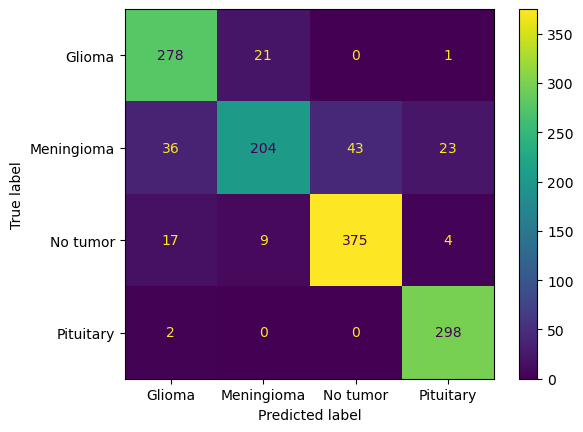

In [57]:
# create a confusion matrix for the model
kn_mcm = confusion_matrix(cnn_y_test, kn_cnn_y_pred, labels = [0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=kn_mcm, display_labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()


<h1>SEQ SVM</h1>

In [16]:
# create and train the SVM classifier via sklearn
cnn_svm=SVC(kernel = 'poly')
cnn_svm.fit(cnn_x_train,cnn_y_train)
cnn_svm.score(cnn_x_train,cnn_y_train)

0.989670868347339

In [58]:
# save the model
dump(cnn_svm, 'cnn_svm.joblib')

['cnn_svm.joblib']

In [ ]:
# load model
cnn_svm = joblib.load("cnn_svm.joblib")

In [17]:
# predict the testing data
svm_cnn_y_predict=cnn_svm.predict(cnn_x_test)

In [29]:
# Obtain evaluation metrics of the model
svm_cnn_accuracy=accuracy_score(cnn_y_test, svm_cnn_y_predict)
svm_cnn_precision = precision_score(cnn_y_test,svm_cnn_y_predict, average = "weighted")
svm_cnn_recall = recall_score(cnn_y_test, svm_cnn_y_predict, average ='weighted')

print("Accuracy:", svm_cnn_accuracy)
print('Precision:', svm_cnn_precision)
print('Recall:', svm_cnn_recall)

Accuracy: 0.9610983981693364
Precision: 0.9614289498005217
Recall: 0.9610983981693364


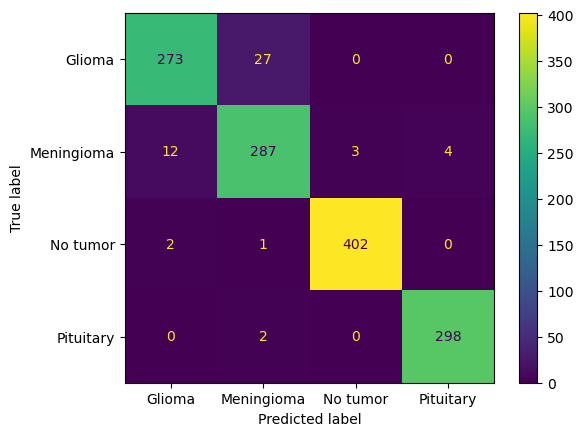

In [60]:
# create a confusion matrix for the model
sv_mcm = confusion_matrix(cnn_y_test, svm_cnn_y_predict, labels = [0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=sv_mcm, display_labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()

<h1>RESNET CNN</h1>

In [9]:
# load the INNCEPTION RESNET V2 model
IMG_SHAPE = IMG_SIZE + (3,)
inception_resnetv2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SHAPE),
    pooling="avg",
    classes=4,
)
print(IMG_SHAPE)


(180, 180, 3)


In [10]:
# create a layer to properly preprocess the data for the network
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [11]:
# set the model to untrainable for the intial round to train the additional dense layers and softmax classifier
inception_resnetv2.trainable = False

In [19]:
# create the model with the additional classifier
inputx = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputx)
x = preprocess_input(x)
x = inception_resnetv2(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256,activation="relu", kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = 'softmax', name = 'outputs')(x)
outputx = x
model = tf.keras.Model(inputx, outputx)

In [20]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 180, 180, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 180, 180, 3)       0         
 mbda)                                                           
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                           

In [21]:
# set the base learning rate and compile thhe model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'), tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall')])

In [22]:
# train the model
initial_epochs = 20

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/20
143/143 [==============================] - 23s 108ms/step - loss: 0.9911 - accuracy: 0.6298 - precision: 0.6799 - recall: 0.5681 - val_loss: 0.5319 - val_accuracy: 0.7811 - val_precision: 0.8251 - val_recall: 0.7312
Epoch 2/20
143/143 [==============================] - 13s 89ms/step - loss: 0.6308 - accuracy: 0.7600 - precision: 0.8005 - recall: 0.7123 - val_loss: 0.4626 - val_accuracy: 0.8144 - val_precision: 0.8515 - val_recall: 0.7680
Epoch 3/20
143/143 [==============================] - 13s 91ms/step - loss: 0.5417 - accuracy: 0.7950 - precision: 0.8300 - recall: 0.7573 - val_loss: 0.4208 - val_accuracy: 0.8319 - val_precision: 0.8687 - val_recall: 0.7995
Epoch 4/20
143/143 [==============================] - 13s 88ms/step - loss: 0.4903 - accuracy: 0.8208 - precision: 0.8469 - recall: 0.7805 - val_loss: 0.3963 - val_accuracy: 0.8450 - val_precision: 0.8699 - val_recall: 0.8021
Epoch 5/20
143/143 [==============================] - 13s 90ms/step - loss: 0.4636 - accuracy: 

In [14]:
print("Number of layers in the base model: ", len(inception_resnetv2.layers))

Number of layers in the base model:  781


In [31]:
# now train the transfer learning network on the specific dataset
inception_resnetv2.trainable = True

# leave the first 200 layers as untrainable
fine_tune_at = 200

for layer in inception_resnetv2.layers[:fine_tune_at]:
  layer.trainable = False

In [33]:
# compile the new model with the trainable InceptionResNetv2 layer
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'), tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall')])



In [35]:
# continue trainging
history_fine = model.fit(train_dataset,
                         epochs=40,
                         initial_epoch=20,
                         validation_data=val_dataset)

Epoch 21/40
143/143 [==============================] - 26s 182ms/step - loss: 0.0046 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - val_loss: 0.1337 - val_accuracy: 0.9746 - val_precision: 0.9746 - val_recall: 0.9737
Epoch 22/40
143/143 [==============================] - 27s 188ms/step - loss: 0.0065 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - val_loss: 0.1406 - val_accuracy: 0.9746 - val_precision: 0.9755 - val_recall: 0.9746
Epoch 23/40
143/143 [==============================] - 27s 192ms/step - loss: 0.0032 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - val_loss: 0.1330 - val_accuracy: 0.9737 - val_precision: 0.9737 - val_recall: 0.9737
Epoch 24/40
143/143 [==============================] - 27s 186ms/step - loss: 0.0028 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - val_loss: 0.1331 - val_accuracy: 0.9764 - val_precision: 0.9764 - val_recall: 0.9764
Epoch 25/40
143/143 [==============================] - 26s 182ms/step - loss: 0.0031 - a

In [36]:
# save model
model.save('Res_Model')

INFO:tensorflow:Assets written to: Res_Model/assets


INFO:tensorflow:Assets written to: Res_Model/assets


In [ ]:
# load the resnet model
res_model = tf.keras.models.load_model('Res_Model', compile=False)

In [ ]:
# Graph accuracy and loss of the training and validation datasets
epochs = len(history.epoch)
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0.6, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 0.5)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Graph the precision and recall of the training and validation datasets
epochs = len(history.epoch)
precision = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['recall']
val_loss = history.history['val_recall']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Recall')
plt.plot(epochs_range, val_loss, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')
plt.show()

In [ ]:
# predict the testing dataset and obtain results
scores = model.evaluate(test_dataset)
scores

<h1>RESNET KNN</h1>

In [ ]:
# load the resnet model
res_model = tf.keras.models.load_model('Res_Model', compile=False)

In [39]:
# remove all items following the resnet layer
kn_res_net = Model(inputs=model.inputs,outputs=model.layers[-5].output)

In [40]:
# save the feature extractor
kn_res_net.save('kn_res')

INFO:tensorflow:Assets written to: kn_res/assets


INFO:tensorflow:Assets written to: kn_res/assets


In [69]:
# load feature extractor
res_model = tf.keras.models.load_model('kn_res', compile=False)

In [77]:
# Obtain our extracted features by running the non shuffled dataset through the feature extraction model
res_train_x=res_model.predict(tr_train_dataset)
res_test_x=res_model.predict(tr_test_dataset)

41/41 [==============================] - 142s 3s/step


In [78]:
# Convert y labels from one hot to integer
res_y_train=[ np.where(r==1)[0][0] for r in  train_label]
res_y_test=[ np.where(r==1)[0][0] for r in  test_label]

In [98]:
# create and train the KNN classifier
res_knc=KNeighborsClassifier()
res_knc.fit(res_train_x,res_y_train)
res_knc.score(res_train_x,res_y_train)

0.9952731092436975

In [46]:
# save the model
dump(res_knc, 'res_knc.joblib')

['res_knc.joblib']

In [75]:
res_knc = joblib.load("res_knc.joblib")

In [99]:
# Obtain the predicted y values for our dataset
kn_res_y_pred = res_knc.predict(res_test_x)


In [100]:
# Gather evaluation metrics
kn_res_accuracy = accuracy_score(res_y_test, kn_res_y_pred)
kn_res_precision = precision_score(res_y_test,kn_res_y_pred, average = "weighted")
kn_res_recall = recall_score(res_y_test, kn_res_y_pred, average = "weighted")

print("Accuracy:", kn_res_accuracy)
print("Precision:", kn_res_precision)
print("Recall:", kn_res_recall)

Accuracy: 0.9877955758962624
Precision: 0.9877910078078872
Recall: 0.9877955758962624


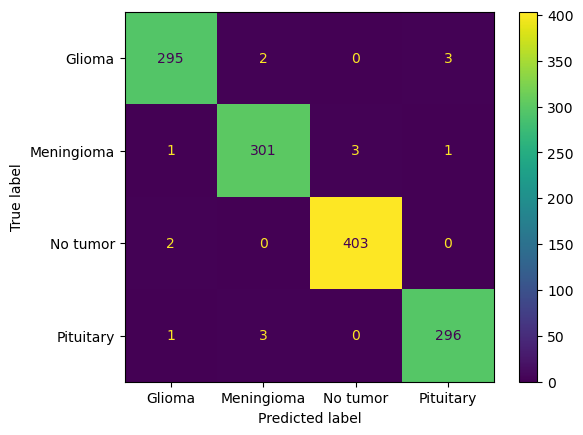

In [101]:
# create a confusion matrix for the model
res_kn_mcm = confusion_matrix(res_y_test, kn_res_y_pred, labels = [0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=res_kn_mcm, display_labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()

<h1>RESNET SVM</h1>

In [92]:
# create the SVM model
res_svm=SVC(kernel = 'poly')
res_svm.fit(res_train_x,res_y_train)
res_svm.score(res_train_x, res_y_train)

0.998249299719888

In [93]:
dump(res_knc, 'res_svm.joblib')

['res_svm.joblib']

In [94]:
res_svm = joblib.load("res_svm.joblib")

In [95]:
svm_res_y_predict=res_svm.predict(res_test_x)

In [96]:
svm_res_accuracy=accuracy_score(res_y_test, svm_res_y_predict)
svm_res_precision = precision_score(res_y_test,svm_res_y_predict, average = "weighted")
svm_res_recall = recall_score(res_y_test, svm_res_y_predict, average ='weighted')

print("Accuracy:", svm_res_accuracy)
print('Precision:', svm_res_precision)
print('Recall:', svm_res_recall)

Accuracy: 0.9877955758962624
Precision: 0.9877910078078872
Recall: 0.9877955758962624


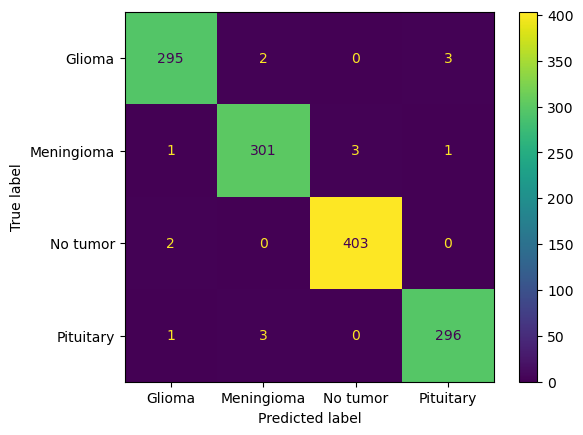

In [97]:
# create a confusion matrix for the model
res_sv_mcm = confusion_matrix(res_y_test, svm_res_y_predict, labels = [0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=res_sv_mcm, display_labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()